# Preparation

In [31]:
import os
import sys

import pandas as pd
from joblib import dump, load

pd.set_option("mode.copy_on_write", True)

script_dir = os.path.abspath("")
mymodule_dir = os.path.join(script_dir, "..", "scripts")
sys.path.append(mymodule_dir)
import cleaning
from nlp import tokenize_doc

jobs = cleaning.prep(
    pd.read_pickle("../data/jobs.pkl"), filtered=True, categories_reduced=False
)
# jobs.head()

In [15]:
jobs = jobs[
    (jobs["Description"] != "Nicht stepstone")
    & (jobs["Description"] != "Stellenanzeige nicht mehr verfügbar")
    & (jobs["Description"] != "")
    & (jobs["Profile"] != "")
]
texts = jobs["Titel"] + " " + jobs["Description"] + " " + jobs["Profile"]

# Preprocessing

In [16]:
import pickle

if os.path.isfile("../data/lemmatized.pkl"):
    with open("../data/lemmatized.pkl", "rb") as file:
        old_lemmas = pickle.load(file)
else:
    old_lemmas = []

lemmas = old_lemmas

docs = [doc for doc in texts]

if len(docs) > len(old_lemmas):
    new_docs = docs[len(old_lemmas) :]
    docs_count = len(new_docs)
    new_lemmas = []
    print(f"Tokenizing {docs_count} documents")
    i = 1
    for doc in new_docs:
        if i % 500 == 0:
            print(f"{i}/{docs_count}")
        new_lemmas.append(tokenize_doc(doc))
        i += 1
    lemmas += new_lemmas
        
    with open("../data/lemmatized.pkl", "wb") as file:
        pickle.dump(lemmas, file)

Tokenizing 2589 documents
500/2589
1000/2589
1500/2589
2000/2589
2500/2589


In [17]:
from collections import Counter

all_in_one = [w for doc in lemmas for w in doc]
bow = Counter(all_in_one)
bow.most_common(10)

[('data', 4401),
 ('business', 2640),
 ('team', 2469),
 ('analyst', 2434),
 ('bereich', 2385),
 ('erfahrung', 2237),
 ('analyse', 2177),
 ('kenntnis', 2128),
 ('abgeschlossen', 1639),
 ('studium', 1567)]

In [37]:
from time import time

import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Feature Extraction using TfidfVectorizer


def custom_tokenizer(x):
    return x

def custom_preprocessor(x):
    return x

vectorizer = TfidfVectorizer(
    tokenizer=custom_tokenizer,
    preprocessor=custom_preprocessor,
    min_df=5,
    max_df=0.8,
)

t0 = time()
X_tfidf = vectorizer.fit_transform(lemmas)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

print(f"Sparsity: {X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

# Performing dimensionality reduction using LSA
lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


vectorization done in 0.259 s
n_samples: 2589, n_features: 5456
Sparsity: 0.016
LSA done in 1.327 s
Explained variance of the SVD step: 28.6%


In [39]:
dump(vectorizer, "../models/vectorizer.joblib")
dump(lsa, "../models/lsa.joblib")

['../models/lsa.joblib']

# Clustering with kmeans

In [26]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


def cluster_means(n, X_lsa):
    t0 = time()

    inertias = {}
    for k in range(1, n):
        kmeans = KMeans(n_clusters=k, max_iter=100, n_init=1, random_state=1)

        kmeans.fit(X_lsa)
        inertias[k] = kmeans.inertia_

    print(f"Clustering done in {time() - t0:.3f} s")

    plt.figure()
    plt.plot(inertias.keys(), inertias.values())
    plt.xlabel("Number of clusters")
    plt.ylabel("Inertia")
    plt.show()


def terms_per_cluster(lsa, vectorizer, kmeans, n):
    original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()

    for i in range(n):
        print(f"Cluster {i}: ", end="")
        for ind in order_centroids[i, :20]:
            print(f"{terms[ind]} ", end="")
        print()

Clustering done in 2.266 s


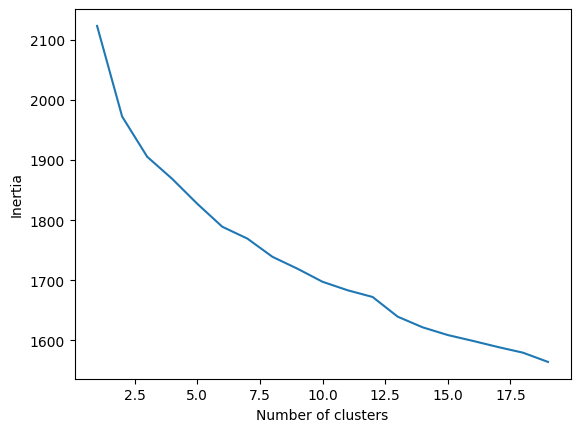

In [27]:
cluster_means(20, X_lsa)

# Top terms per Cluster

Cluster 0: data science learning machine erfahrung bereich scientist entwicklung kenntnis modell datum analytic python team informatik methode ki mathematik statistik analyse 
Cluster 1: erstellung kenntnis m analyse bereich office controlling abgeschlossen analytisch hoch umgang analyst studium excel insbesondere fähigkeit erfahrung berufserfahrung unterstützung arbeitsweise 
Cluster 2: experience business skills financial analysis project management supporen work strong risk processes data knowledg development analytical team degree working finance 
Cluster 3: business anforderung prozeß fachlich erfahrung technisch analyst agil team bereich kunde projekt security arbeiten vergleichbar fachbereich kenntnis lösung studium unser 
Cluster 4: sein datum data analyse analytic marketing power bereich kenntnis business erfahrung dashboard sql analyst tool datenanalyse report analytisch studium intelligence 
Cluster 5: data experience science team skills work product business knowledg model 

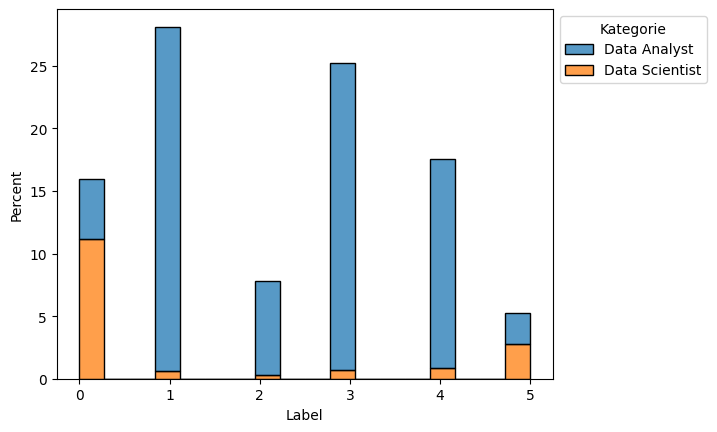

In [28]:
import seaborn as sns

cluster_count = 6
kmeans = KMeans(n_clusters=cluster_count, max_iter=100, n_init=1, random_state=2)


kmeans.fit(X_lsa)


labels = kmeans.labels_

df_eval = pd.DataFrame({"Label": labels, "Kategorie": jobs.iloc[:, 18]})

# display(df_eval.groupby("Kategorie").value_counts(subset=["Label"], normalize=True))
by_label = df_eval.groupby("Label").value_counts(subset=["Kategorie"], normalize=True)

ax = sns.histplot(
    data=df_eval, x="Label", hue="Kategorie", multiple="stack", stat="percent"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

terms_per_cluster(lsa, vectorizer, kmeans, cluster_count)

In [29]:
dump(kmeans, "../models/kmeans.joblib")

['../models/kmeans.joblib']